# **Notebook contents:**

Solving the same grid problem with monte-carlo updates.

Introducing a small change in the value calculation according to montecarlo value update system.

The entire notebook would be the same as cumulative discounted average method. But, the way we populate the value look-up table in the Training loop section changes to suit the following equation.

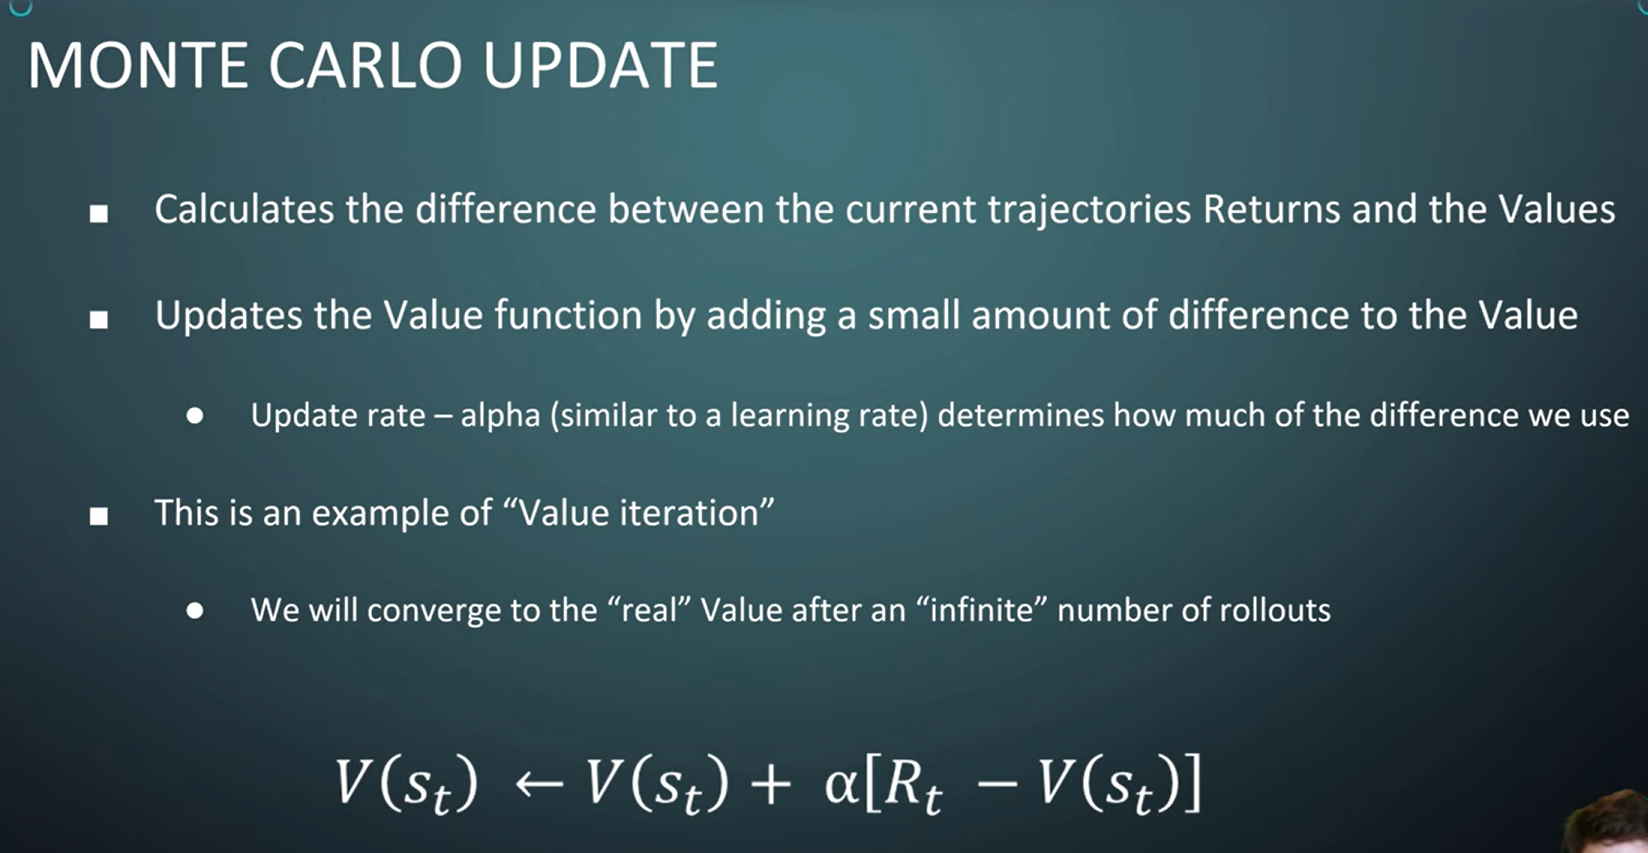

Here, α (learning rate) controls how much the new information influences the state value, reducing the impact of noisy or extreme returns. The Monte Carlo incremental update reduces variance because it doesn’t treat every past trajectory equally but instead adjusts values gradually.


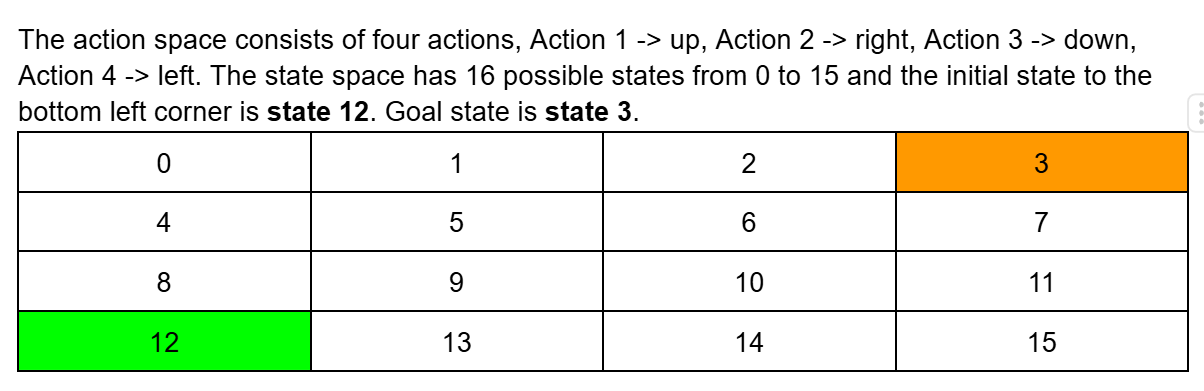

* State 12 is the initial state.
* State 3 is the goal state or the reward state.


# 1 Define the Environment

Our first job is to design the environment or in other words, define the reward function according to the problem we are trying to solve.

## Imports

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Reward function definition

In [2]:
rewards = np.zeros(16)
rewards[3] = 1
# rewards[2] = 0
# rewards[11] = 0
# rewards[10] = 0 # This commented code is doing nothing at the moment
# Later we use things like this to set some advantages and disadvantages to the said grid cell

terminal_state = 3
state_values = np.zeros(16)
alpha = 0.005
score_log = []

In [3]:
rewards

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

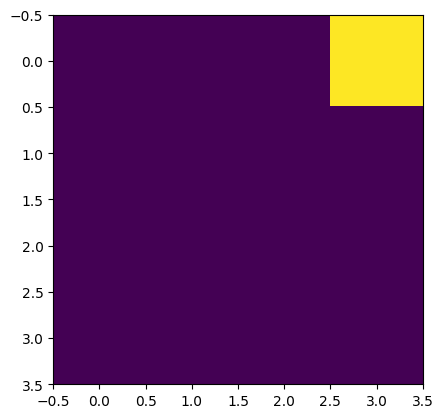

In [4]:
plt.imshow(rewards.reshape(4,4))

## State transition table

The following is our state transition table. We have 16 possible states in total from 0 to 15 and this table respresents how all the possible actions ie., Four actions 1 -> up, 2 -> right, 3 -> down, 4-> left affect the state transitions.

In [5]:
file_path = "/content/drive/MyDrive/Colab_Notebooks/Reinforcement_Learning_notebooks/Grid_world_example/state_transitions.csv"
state_transition_table = np.genfromtxt(file_path, delimiter=",").astype(int)

In [6]:
state_transition_table

array([[ 0,  1,  4,  0],
       [ 1,  2,  5,  0],
       [ 2,  3,  6,  1],
       [ 3,  3,  7,  2],
       [ 0,  5,  8,  4],
       [ 1,  6,  9,  4],
       [ 2,  7, 10,  5],
       [ 3,  7, 11,  6],
       [ 4,  9, 12,  8],
       [ 5, 10, 13,  8],
       [ 6, 11, 14,  9],
       [ 7, 11, 15, 10],
       [ 8, 13, 12, 12],
       [ 9, 14, 13, 12],
       [10, 15, 14, 13],
       [11, 15, 15, 14]])

In [7]:
state_transition_table[0]

array([0, 1, 4, 0])

## Calculating the returns using cumulative discounted average method

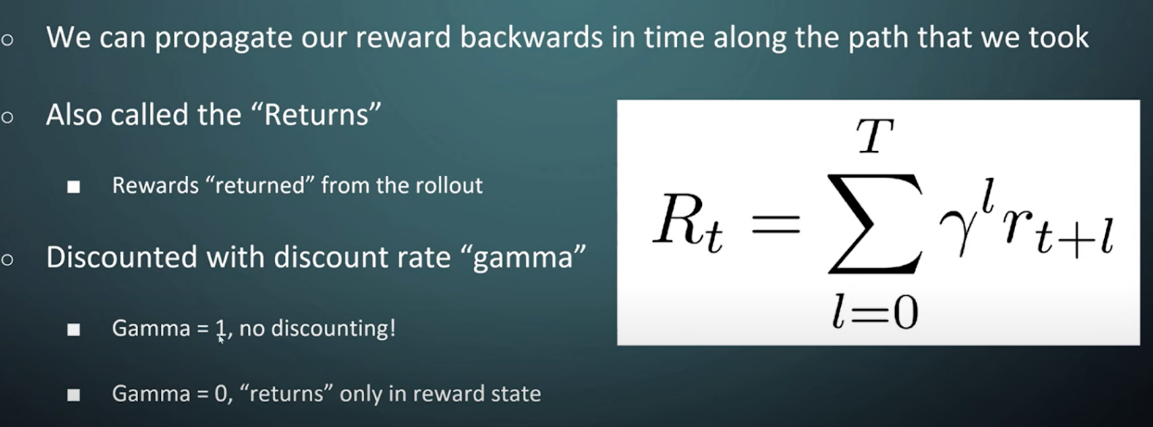

As seen above, we can calculate the "returns" of a specific trajectory by propogating our reward backwards in time.

Returns:
Each grid cell has a reward value associated with it. That is what we have seen in the above reward function definition section.

Now, instead of only using the reward signal which is very sparse in our example, as we are only giving reward to the goal state, to ensure that we find the most optimal way of finding the reward, we implement this algorithm called "Cumulative discounted rewards" and use returns as a metric to evaluate how optimal our path is.

Larger trajectories have lower returns and smaller trajectories have higher returns. This is how, we are ensuring that the model prefers smaller trajectories i.e., trajectories where the agent finds the reward goal state in less time steps.

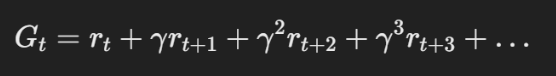

In [8]:
def returns(values, rewards, states): # We are not using values yet
    state_count = np.zeros(16) # Keeps a track of how many times a state has been visited
    state_returns = np.zeros(16) # Returns values for each state
    r = 0
    gamma = 0.9
    for i in reversed(range(len(rewards))): # Gives the iteration from 15 to 0
        r = rewards[i] + gamma * r
        state_returns[states[i]] += r # In monte-carlo we don't need to keep track of the state returns
        state_count[states[i]] += 1 # And number of times, the agent has visited a specific state.
#         print(states[i])

    return state_returns/(state_count + 1e-10) #1e-10 is just to ensure numerical stability(/0) for the states we have never visited.
    # We are returning this value to just prevent accumulation of rewards over multiple visits to a state in a given trajectory.

In [9]:
# We are defining another function instead, return values generation of the entire trajectory follows the same steps as above
# Now, we don't need to remember the entire return grid
# We will just update the value function as we go.

def monte_carlo_update(values, rewards, states): # We pass the current state values, rewards of the current trajectory and state_log info of the current trajectory as args
  returns = [] # Initialize an empty returns for this trajectory that we are calling the monte_carlo update
  R = 0 # Initialize the return grid values for the respective trajectory
  gamma = 0.9

  for i in reversed(range(len(rewards))): # Gives the iteration from last reward to first reward
        R = rewards[i] + gamma * R
        returns.insert(0,R) # We are inserting before to ensure that the returns of the grid cell are associated in the same order and not the reverse order

  values[states] = values[states] + alpha*(returns-values[states])
  # returns -> Returns of different grid cells along trajectory
  # values[states] -> Values of states along the trajectory
  return values

## Test agent (single trajectory)

test_agent() describes a single trajectory that happens during test time.

The entire work flow would be:
1. Have a reward function
2. Training: Set multiple trajectories and give returns values to every single trajectory. Also assign values to states based on the average values of rewards in each trajectory.
3. Test time: Now, we have values of all the states and we just traverse our test agent by selecting the next state with the highest value from the state transition matrix.

In [10]:
def test_agent():
    state = 12 #  Starting with Initial state
    done = False
    steps = 0
    total_rewards = 0
    states_log = []
    while (not(state == terminal_state)) and steps<30:
        states_log.append(state) # log the current state
        action = np.argmax(state_values[state_transition_table[state]]) # Choose the action that gets us into the state with highest value
        state = state_transition_table[state, action] # Updating state based on the action taken
        total_rewards += rewards[state]
        steps += 1
    states_log.append(state)
    return total_rewards, states_log # returns total rewards collected along the trajectory and a log of states and their transitions

## Training loop over multiple trajectories

We get returns grids for every single trajectory. A return grid is nothing but the return value of every cell in one trajectory. If we haven't touched that particular cell in the trajectory, the return grid's corresponding value to the respective cell would be 0.

In [11]:
returns_log = [] # returns_log is the logging of return grids
number_of_trajectories = 1000
for _ in range(number_of_trajectories):
    state = 12 # Starting with the initial state
    state_log = [] # Initializing the state_log and reward_log values for the current trajectory
    reward_log = []
    steps = 0

    # This while logic to finish the current trajectory from the initial position to the goal state
    while (not(state == terminal_state)) and steps<30:
        reward_log.append(rewards[state])
        state_log.append(state)

        action = random.randint(0,3) # Taking a random action among the four possible ones
        state = state_transition_table[state, action] # And going to the next state on the basis of the action taken
        steps += 1

    # For the current trajectory, we have the rewardslog and states log values.
    # We are creating a return grid by using the cumulative discounted rewards function we have previously defined.
    reward_log.append(rewards[state])
    state_log.append(state)

    # We don't need returns_log anymore
    # Let us directly update state values
    state_values = monte_carlo_update(state_values, reward_log, state_log)

    # Once, we get the returns_log of our current trajectory, we update the value-look up table by taking the average of current trajectory and previous ones.

    score_log.append(test_agent()[0]) # score is the reward that the test agent gets in the trajectory, which is nothing but cumulative rewards across the trajectory.

In [12]:
state_log # These are the state values at the respective time steps in the final trajectory

[12,
 12,
 12,
 13,
 9,
 8,
 8,
 8,
 4,
 0,
 4,
 4,
 5,
 4,
 8,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 4,
 0,
 0,
 0,
 0,
 4,
 4]

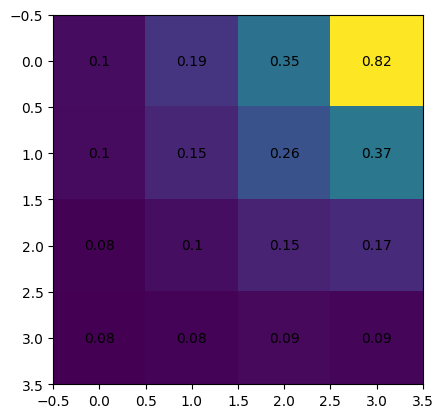

In [13]:
fig1, ax1= plt.subplots(1)
ax1.imshow(state_values.reshape(4, 4))

for (j,i), label in np.ndenumerate(state_values.reshape(4, 4).round(2)):
    ax1.text(i,j,label,ha='center',va='center')

We can observe that the states closer to the goal state have higher values and the states farther away have lower values.

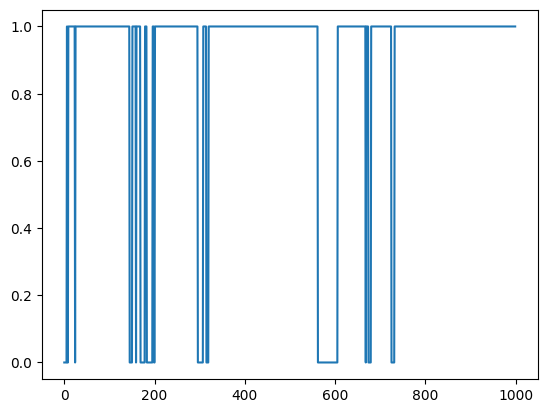

In [14]:
plt.plot(score_log)

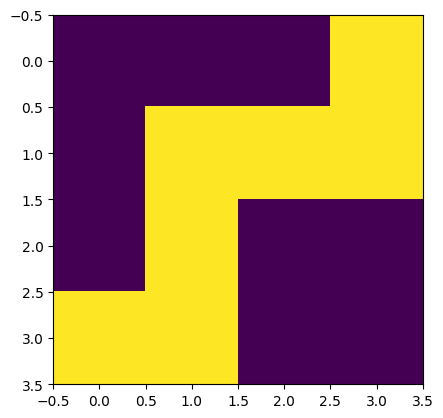

In [15]:
_, state_log = test_agent() # state_log stores the states visited by the test_agent()
state_view = np.zeros(16) # Initializing a state_view array to view the states visited by the test agent
state_view[state_log] = 1 # Setting the value of the states visited by the test agent as 1
plt.imshow(state_view.reshape(4,4))

In [16]:
state_transition_table[12]

array([ 8, 13, 12, 12])

In [17]:
state_values[state_transition_table[12]]
# Values of the four states, we have assigned from the returns_log array collected over multiple trajectories

array([0.08044449, 0.08144388, 0.07556186, 0.07556186])

The output is much nicer. We are not logging returns and we have smoothed out some noise.

We can make it better!!!

We still have some noise in our monte carlo updates.

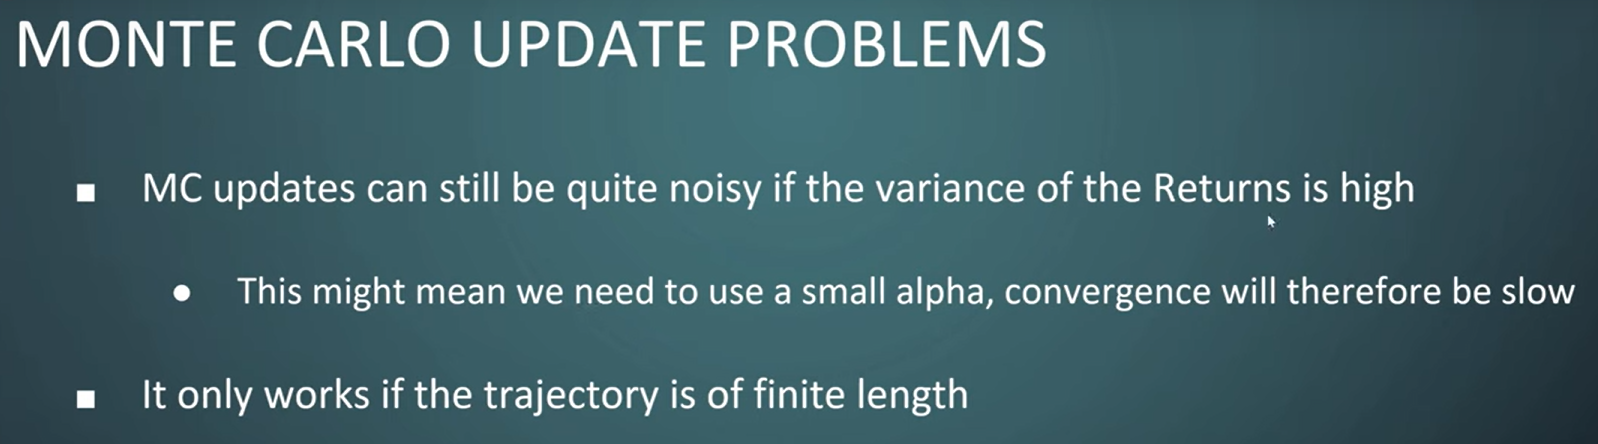

There is a chance of the agent stopping near to the goal state, just because it has timed out.

# **TEMPORAL DIFFERENCE !!!!!!**